In [1]:
from xclib.data import data_utils
import numpy as np
import pandas as pd
from math import log2
import time
import matplotlib.pyplot as plt

# Reading the data-set

In [2]:
# Read sparse file
train_x = data_utils.read_sparse_file('ass3_parta_data/train_x.txt', force_header=True)
train_x = np.array(train_x.toarray(),dtype =int)
train_y = pd.read_csv('ass3_parta_data/train_y.txt', sep="\n", header=None).to_numpy()

test_x = data_utils.read_sparse_file('ass3_parta_data/test_x.txt', force_header=True)
test_x = np.array(test_x.toarray(),dtype =int)
test_y = pd.read_csv('ass3_parta_data/test_y.txt', sep="\n", header=None).to_numpy()

val_x = data_utils.read_sparse_file('ass3_parta_data/valid_x.txt', force_header=True)
val_x = np.array(val_x.toarray(),dtype =int)
val_y = pd.read_csv('ass3_parta_data/valid_y.txt', sep="\n", header=None).to_numpy()

/home/vivek/.local/lib/python3.6/site-packages/xclib-0.96-py3.6-linux-x86_64.egg/xclib/data/data_utils.py:173: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


# Calculating Entropy

In [3]:
def entropy(data):
    """
    Calculates the uncertanity of data :
    sparse distibuted data low entropy
    mixed distibuted data high entropy
    """
    totaldata = data.shape[0]
    Y = data[:,-1]
    Totalpositive = Y[Y==1].size
    Totalnegative = Y[Y==0].size
    H = 0 
    
    # When only one class of data -> Pure
    if Totalpositive ==0 or Totalnegative ==0:
        return 0
    
    else:
        positive_ratio = Totalpositive/totaldata
        negative_ratio = Totalnegative/totaldata
        H = -positive_ratio * log2(positive_ratio) + (-negative_ratio * log2(negative_ratio))
        return H

# Finding Info-gain 

In [4]:
def info_gain(data,true_data_index,false_data_index,H):
    """
    Takes data, entropy of that data (H)
    as well as a col number to find info_gain 
    if we split on that col median
    """

    totalDataSize =data.shape[0]
    true_data = data[true_data_index]
    false_data = data[false_data_index]
    
    true_branch_ratio = true_data.shape[0]/totalDataSize
    false_branch_ratio = false_data.shape[0]/totalDataSize  

    if true_branch_ratio == 0 or false_branch_ratio ==0:
        return 0
    
    trueEntropy  = entropy(true_data)
    falseEntropy = entropy(false_data)
    
    I = H - ((true_branch_ratio * trueEntropy) + (false_branch_ratio * falseEntropy))
    return I

In [5]:
def best_split(data,H):
    
    best_info_gain = -1
    best_attr = -1
    split_median = -1
    trueIndex = None
    falseIndex = None
    
    # consider all attributes except the last one i.e label *y*
    medianList  = np.median(data[:,:-1],axis =0)
    
    true_data_index = data[:,:-1] <= medianList
    false_data_index = data[:,:-1] > medianList

    totalcol= data[:,:-1].shape[1]
    for colIndex in range(totalcol):
        
        IG = info_gain(data,true_data_index[:,colIndex],false_data_index[:,colIndex],H)

        if IG > best_info_gain:
            best_info_gain = IG
            best_attr = colIndex
            split_median = medianList[colIndex]
            trueIndex = true_data_index[:,colIndex]
            falseIndex = false_data_index[:,colIndex]

    return best_attr, split_median, trueIndex,falseIndex, best_info_gain

# Decision Node Class

Stores necessary info at each node of the decison tree model.

In [6]:
class Decision_nodes:

    total_decision_nodes = 0
    depth = 0
    
    def __init__(self,depth):
        self.depth = depth
        self.left_child =None
        self.right_chid = None
        self.column = None
        self.split_median = None
        self.label = None
        self.parent = None
        

        self.val_x_index  = None
        
        
        self.train_acc = 0
        self.test_acc = 0
        self.val_acc = 0
        
        #----------Class Variable ---------------
        #counts number of nodes created each time a new node is created
        Decision_nodes.total_decision_nodes+=1
        
        if depth > Decision_nodes.depth:
            Decision_nodes.depth = depth
        #----------------------------------------

    def assignLabel(self,data):
        if sum(data[:,-1]==0) >= sum(data[:,-1]==1):
            self.label = 0
        else:
            self.label = 1
            
            
    @classmethod        
    def get_node_count(cls):
        return cls.total_decision_nodes
    @classmethod
    def reset_node_count(cls):
        cls.total_decision_nodes = 0



# Decision Tree Class

Contains Following Methods: <br>
calculate_acc : Calculate accuracy at each node while tree grows <br>
Build_tree : Creating tree recursively <br>
Predict : Finds Accuracy for a given data <br>
node_count : Total nodes in Tree *present* <br>
get_all_decesion_nodes : Returns List of all nodes preset in tree *Level Wise* <br>
pruning : Method to prune fully grown tree with Validation data

In [7]:
class Decision_tree:
    

    
    
    def __init__(self,node,train_y,test_y,val_y):
        
        self.root = node
        
        self.train_y_pred = [-1]*train_y.shape[0]
        self.test_y_pred  = [-1]*test_y.shape[0]
        self.val_y_pred = [-1]*val_y.shape[0]
        
        self.train_y = train_y
        self.test_y = test_y
        self.val_y = val_y
        
        self.match_train = 0
        self.match_test = 0
        self.match_val = 0
        
        self.train_accuracy = []
        self.test_accuracy = []
        self.val_accuracy = []
        
       

    def calculate_acc(self,label, Train_data, Test_data, Val_data):
#         label =  node.label
        
        new_match_train = 0
        for row in Train_data:
            index = row[-1]
            if label == self.train_y_pred[index] :
                continue
            elif label != self.train_y_pred[index]  and label == self.train_y[index]:
                self.train_y_pred[index] = label
                new_match_train+=1
            elif label != self.train_y_pred[index]  and label != self.train_y[index]:
                if self.train_y_pred[index] == -1:
                    self.train_y_pred[index] = label
                    continue
                else:
                    self.train_y_pred[index] = label
                    new_match_train-=1
                    
        final_match_train = self.match_train + new_match_train
        
        new_match_test = 0
        for row in Test_data:
            index = row[-1]
            if label == self.test_y_pred[index] :
                continue
            elif label != self.test_y_pred[index]  and label == self.test_y[index]:
                self.test_y_pred[index] = label
                new_match_test+=1
            elif label != self.test_y_pred[index]  and label != self.test_y[index]:
                if self.test_y_pred[index] == -1:
                    self.test_y_pred[index] = label
                    continue
                else:
                    self.test_y_pred[index] = label
                    new_match_test-=1
        final_match_test = self.match_test + new_match_test
        
        new_match_val = 0
        for row in Val_data:
            index = row[-1]
            if label == self.val_y_pred[index] :
                continue
            elif label != self.val_y_pred[index]  and label == self.val_y[index]:
                self.val_y_pred[index] = label
                new_match_val+=1
            elif label != self.val_y_pred[index]  and label != self.val_y[index]:
                if self.val_y_pred[index] == -1:
                    self.val_y_pred[index] = label
                    continue
                else:
                    self.val_y_pred[index] = label
                    new_match_val-=1
        final_match_val = self.match_val + new_match_val
        
        acc_train = final_match_train/train_y.shape[0]
        acc_test = final_match_test/test_y.shape[0]
        acc_val = final_match_val/val_y.shape[0]
        return final_match_train,final_match_test, final_match_val,acc_train, acc_test, acc_val
        
        
        
                

    def Build_tree(self,node, data, Train_data, Test_data, Val_data):


        H = entropy(data)
        node.assignLabel(data)

        node.val_x_index = Val_data[:,-1]
        best_attr, split_median, trueIndex, falseIndex, best_info_gain =  best_split(data,H)
        
        #---------------------------------------------------
        final_match_train,final_match_test, final_match_val,acc_train, acc_test, acc_val = self.calculate_acc(node.label,
                                                                                                              Train_data, 
                                                                                                              Test_data, 
                                                                                                              Val_data)

        self.match_train = final_match_train
        self.match_test = final_match_test
        self.match_val = final_match_val
        
        node.train_acc = final_match_train
        node.test_acc = final_match_test
        node.val_acc = final_match_val
        #---------------------------------------------------
        
        nc = Decision_nodes.get_node_count()

#         if nc==1 or nc%88 == 1:
#             print("node count ",nc)
#             print("train_acc ",acc_train,"test_acc ",acc_test,"val_acc ",acc_val)
        self.train_accuracy.append((nc,acc_train))
        self.test_accuracy.append((nc,acc_test))
        self.val_accuracy.append((nc,acc_val))

        if H ==0 or best_attr == -1 or best_info_gain <= 0:
            return #LEAF

        true_branch = data[trueIndex]
        false_branch = data[falseIndex]

        if true_branch.shape[0] ==0 or false_branch.shape[0]==0:
            return #LEAF
        

        
        node.column  = best_attr
        node.split_median = split_median


        Train_data_left = Train_data[Train_data[:,best_attr] <= split_median]
        Train_data_right = Train_data[Train_data[:,best_attr] > split_median]

        Test_data_left = Test_data[Test_data[:,best_attr] <= split_median]
        Test_data_right = Test_data[Test_data[:,best_attr] > split_median]

        Val_data_left = Val_data[Val_data[:,best_attr] <= split_median]
        Val_data_right = Val_data[Val_data[:,best_attr] > split_median]

        left_node =  Decision_nodes(node.depth+1)
        right_node = Decision_nodes(node.depth+1)
        
        left_node.parent = node
        right_node.parent = node

        node.left_child = left_node
        self.Build_tree(left_node, true_branch, Train_data_left, Test_data_left, Val_data_left)
        node.right_chid = right_node
        self. Build_tree(right_node, false_branch, Train_data_right, Test_data_right, Val_data_right)

        return 
         
        


    def classify(self,x,node,mode):
     
            
        if node.left_child ==None and node.right_chid ==None:
            for row in x:
                index=row[-1]
                if mode =='val':
                    self.val_y_pred[index]  = node.label
                elif mode == 'train':
                    self.train_y_pred[index]  = node.label
                elif mode == 'test':
                    self.test_y_pred[index] = node.label
            return 

        col = node.column
        median = node.split_median

        left_x = x[x[:,col] <= median]
        right_x = x[x[:,col] > median]

        self.classify(left_x,node.left_child,mode)    
        self.classify(right_x,node.right_chid,mode)
        return 
    
        

        
    def predict(self,x,y):
        mode =''
        if y.shape[0] == len(self.val_y_pred):
            mode ='val'
            y_pred = self.val_y_pred
        elif y.shape[0] == len(self.train_y_pred):
            mode = 'train'
            y_pred = self.train_y_pred
        elif y.shape[0] == len(self.test_y_pred):
            mode = 'test'
            y_pred = self.test_y_pred
            
        match = 0
        x = np.append(x,np.arange(y.shape[0]).reshape((-1,1)),axis =1)
        self.classify(x, self.root, mode)
        for i in range(len(y_pred)):
            if y_pred[i] == y[i]:
                match += 1
        return match/y.shape[0]
    
    def node_count(self):
        count = 0
        queue = []
        queue.append(self.root)
        while(len(queue)!=0):
            count+=1
            node = queue.pop(0)
            if node.left_child:
                queue.append(node.left_child)
            if node.right_chid:
                queue.append(node.right_chid)
        return count
    
    def get_all_decesion_nodes(self):
        nodes_list = []
        
        q = []
        q.append(self.root)
        
        while(len(q)!=0):
            node = q.pop(0)
            if node.left_child:
                q.append(node.left_child)
            if node.right_chid:
                q.append(node.right_chid)
            if node.left_child!=None or node.right_chid!=None :# Decsion node
                nodes_list.append(node)
        return nodes_list
    
    def pruning(self):
        """
        pruning the decesion tree to remove
        overfitting.
        Pruning is done on validation data
        """

        
        train_acc_prune = []
        test_acc_prune = []
        val_acc_prune = []
        node_count_list = []
        
        node_count_list.append(self.node_count())
        train_acc_prune.append(self.predict(train_x,train_y))
        test_acc_prune.append(self.predict(test_x,test_y))
        val_acc_prune.append(self.predict(val_x,val_y))

        count  = 0
        print("entering wihile loop")

        while(True):
            count+=1
            #--------------------------------------------
            best_acc_gain = -1
            best_node_to_prune = None
            
            nodes_list = self.get_all_decesion_nodes()
            
            for node in nodes_list:
               
                y_pred = self.val_y_pred.copy()
                before_match = self.match_val
                before_acc = before_match/len(y_pred)
                after_match = before_match
                
                for index in node.val_x_index:
                    if node.label == y_pred[index]:
                        continue
                    elif node.label != y_pred[index] and node.label == self.val_y[index]:
                        y_pred[index]  = node.label
                        after_match+=1
                    elif node.label != y_pred[index] and node.label != self.val_y[index]:
                        y_pred[index]  = node.label
                        after_match-=1
                    

                after_acc = after_match/len(y_pred) 

                gain  = after_acc - before_acc
                if gain > best_acc_gain:
#                     print("before ",before_acc, self.predict(val_x,val_y) )
                    best_node_to_prune = node
                    best_acc_gain = gain
                    new_val_y_pred = y_pred
                    new_match_val = after_match
            
                    
            #---------------------------------------------    
            
        
            if best_acc_gain < 1e-20 or best_node_to_prune ==None:
                print("stopping here with gain ",best_acc_gain)
                break
            
            self.val_y_pred = new_val_y_pred
            self.match_val = new_match_val
            
            if best_node_to_prune.left_child:
                best_node_to_prune.left_child = None
            if best_node_to_prune.right_chid:
                best_node_to_prune.right_chid = None
            
            if count%300==1:
                node_count_list.append(self.node_count())
                train_acc_prune.append(self.predict(train_x,train_y))
                test_acc_prune.append(self.predict(test_x,test_y))
                val_acc_prune.append(self.predict(val_x,val_y))
            
        node_count_list.append(self.node_count())
        train_acc_prune.append(self.predict(train_x,train_y))
        test_acc_prune.append(self.predict(test_x,test_y))
        val_acc_prune.append(self.predict(val_x,val_y))
        print("train acc {} test acc {} val acc {}".format(self.predict(train_x,train_y),self.predict(test_x,test_y),self.predict(val_x,val_y)))
        tr, = plt.plot(node_count_list,train_acc_prune, label="Train Accuracy")
        te, = plt.plot(node_count_list,test_acc_prune, label ="Test Accuracy")
        vl, = plt.plot(node_count_list,val_acc_prune, label = "Validation Accuracy")
        plt.xlabel("Node Count")
        plt.ylabel("Accuracy")
        plt.title("Accuracy as we prune the nodes")
        plt.legend()
        plt.show()
        return tr,te,vl

# Creating indexed data for speeding the process

In [8]:
def get_indexed_data(train_x,train_y,test_x,test_y,val_x,val_y):
    Train_data = np.append(train_x,train_y.reshape((-1,1)),axis = 1)
    Test_data = np.append(test_x,test_y.reshape((-1,1)),axis = 1)
    Val_data = np.append(val_x,val_y.reshape((-1,1)),axis = 1)
    data = Train_data.copy()
    #index col
    Train_data = np.append(Train_data,np.arange(Train_data.shape[0]).reshape((-1,1)),axis =1)
    Test_data = np.append(Test_data,np.arange(Test_data.shape[0]).reshape((-1,1)),axis =1)
    Val_data = np.append(Val_data,np.arange(Val_data.shape[0]).reshape((-1,1)),axis =1)
    return Train_data, Test_data, Val_data,data

Train_data, Test_data, Val_data, data = get_indexed_data(train_x,train_y,test_x ,test_y ,val_x ,val_y )

# Part A
Growing the tree recusively. <br>
Calculating the accuracy at each node as the tree keeps growing. <br>
Plotting the graph of Nodes vs Accuracy

In [ ]:
s= time.time()

root = Decision_nodes(0)

tree = Decision_tree(root,train_y,test_y ,val_y )

tree.Build_tree(root, data, Train_data, Test_data, Val_data)

print(time.time()-s)

In [ ]:
print("Train {} Test {} Val {}".format(tree.predict(train_x,train_y),tree.predict(test_x,test_y),tree.predict(val_x,val_y)))

In [9]:
# import pickle 
# with open("tree",'wb') as f:
#     pickle.dump(tree,f)

import pickle
with open('tree','rb') as f:
    tree = pickle.load(f)

In [10]:
# %matplotlib qt
def plot_node_vs_acc(tree):
    tr, = plt.plot([i[0] for i in tree.train_accuracy] ,[i[1] for i in tree.train_accuracy],label="train")
    te, = plt.plot([i[0] for i in tree.test_accuracy] ,[i[1] for i in tree.test_accuracy],label="test")
    vl, = plt.plot([i[0] for i in tree.val_accuracy] ,[i[1] for i in tree.val_accuracy],label="val")
    plt.xlabel("Number of nodes")
    plt.ylabel("Accuracies")
    plt.title("Train, Test and Val Accuracy while growing Decision Tree")
    plt.legend()
    plt.show()
    return tr,te,vl

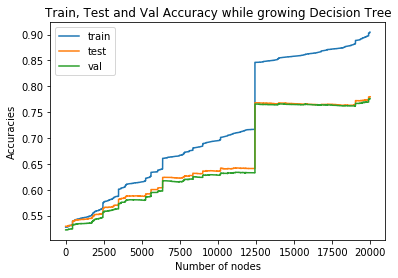

(<matplotlib.lines.Line2D at 0x7f4cc2286898>,
 <matplotlib.lines.Line2D at 0x7f4cc2288080>)

In [11]:
plot_node_vs_acc(tree)

# Part B
Plotting the graph for nodes vs Accuracy in pruning the tree

In [18]:
print(tree.node_count())

4079


In [13]:
post_order=[]
def pot(node):
    if node!=None:
        if node.left_child ==  None and node.right_chid ==None:
            return 
        pot(node.left_child)

        pot(node.right_chid)

        post_order.append(node)     

In [14]:
from tqdm import tqdm
def prun(tree):
    train_acc_prune = []
    test_acc_prune = []
    val_acc_prune = []
    node_count_list = []    
    count = 0
    print(len(post_order))
    for node in tqdm(post_order):
        count+=1
        y_pred = tree.val_y_pred.copy()
        before_match = tree.match_val
        before_acc = before_match/len(y_pred)
        after_match = before_match

        for index in node.val_x_index:
            if node.label == y_pred[index]:
                continue
            elif node.label != y_pred[index] and node.label == tree.val_y[index]:
                y_pred[index]  = node.label
                after_match+=1
            elif node.label != y_pred[index] and node.label != tree.val_y[index]:
                y_pred[index]  = node.label
                after_match-=1
                
        after_acc = after_match/len(y_pred) 
        if after_acc >= before_acc:
            tree.val_y_pred = y_pred
            tree.match_val = after_match
            node.left_child = None
            node.right_chid = None
        if count%1000==1:
            node_count_list.append(tree.node_count())
            train_acc_prune.append(tree.predict(train_x,train_y))
            test_acc_prune.append(tree.predict(test_x,test_y))
            val_acc_prune.append(tree.predict(val_x,val_y))
            
    node_count_list.append(tree.node_count())
    train_acc_prune.append(tree.predict(train_x,train_y))
    test_acc_prune.append(tree.predict(test_x,test_y))
    val_acc_prune.append(tree.predict(val_x,val_y))      
    print("train acc {} test acc {} val acc {}".format(tree.predict(train_x,train_y),tree.predict(test_x,test_y),tree.predict(val_x,val_y)))
    tr, = plt.plot(node_count_list,train_acc_prune, label="Train Accuracy")
    te, = plt.plot(node_count_list,test_acc_prune, label ="Test Accuracy")
    vl, = plt.plot(node_count_list,val_acc_prune, label = "Validation Accuracy")
    plt.xlabel("Node Count")
    plt.ylabel("Accuracy")
    plt.title("Accuracy as we prune the nodes")
    plt.legend()
    plt.show()
    return tr,te,vl

In [15]:
pot(tree.root)

In [16]:
print("total decision nodes",len(post_order))

total decision nodes 9988


  0%|          | 0/9988 [00:00<?, ?it/s]

9988


100%|██████████| 9988/9988 [00:23<00:00, 416.87it/s] 


train acc 0.8321048321048321 test acc 0.7975522692503825 val acc 0.8245410717596885


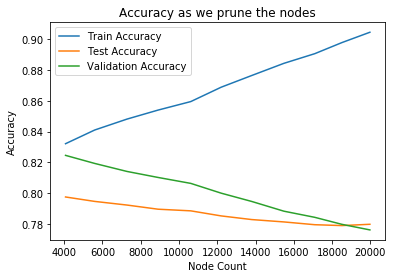

(<matplotlib.lines.Line2D at 0x7f4cc2216f28>,
 <matplotlib.lines.Line2D at 0x7f4cc2216470>)

In [17]:
prun(tree)

In [ ]:
# def classify(row,node,depth):

#     if node.depth == depth:
#         return node.label
#     if node.left_child ==None and node.right_chid ==None:
#         return node.label

#     col = node.column
#     median = node.split_median
#     if row[col] <= median:
#         return classify(row, node.left_child,depth)
#     elif node.right_chid ==None:
#         return node.label
#     else:
#         return classify(row, node.right_chid,depth)

# def depthWiseAcc(x,y):
#     acc = []
#     for i in range(55):
#         r = tree.root
#         prediction = []
#         for row in x:
#             prediction.append(classify(row,r,i))
#         match=0
#         for i in range(len(prediction)):
#             if y[i]==prediction[i]:
#                 match+=1
#         acc.append(match/len(prediction))
        
#     return acc
# tr=depthWiseAcc(train_x,train_y)
# te=depthWiseAcc(test_x,test_y)
# vl = depthWiseAcc(val_x,val_y)

# %matplotlib qt
# plt.plot(np.arange(55),tr,label="train")
# plt.plot(np.arange(55),te,label="test")
# plt.plot(np.arange(55),vl,label="val")
# plt.xlabel("Levels in Decision Tree")
# plt.ylabel("Accuracies")
# plt.title("Train, Test and Val Accuracy while growing Decision Tree Level Wise")
# plt.legend()
# plt.show()

# Part C

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_test = {'n_estimators':np.arange(50,550,100),
              'max_features':np.arange(0.1,1.0,0.2),
              'min_samples_split': np.arange(2,12,2)}

In [ ]:
from sklearn.metrics import  make_scorer
def oob_score(model,X,Y):
    return model.oob_score_
  
# score = make_scorer(oob_score)
forest =  RandomForestClassifier(n_jobs=-1,oob_score=True)

search = GridSearchCV(estimator=forest, param_grid=param_test, cv=3,verbose=3,scoring=oob_score)

In [ ]:
search.fit(train_x, train_y.ravel())

In [ ]:
 print(search.best_params_)

__ n_estimators:  350 __ <br>
__ max_features:  0.1 __ <br>
__ min_samples_split:  10 __ <br>

# Part D

In [ ]:
n_estimators = np.arange(50,1000,100)
a=np.linspace(0.01,0.1,10)
b=np.linspace(0.2,0.9,10)
max_features = np.append(a,b)
min_samples_split =  np.arange(2,50,2)

In [ ]:
def n_estimators_plot():
    n_estimators_test_acc = []
    n_estimators_val_acc = []
    for i in n_estimators:
        model = RandomForestClassifier(n_jobs=-1,max_features = 0.1,min_samples_split = 10 ,n_estimators=i)
        model.fit(train_x,train_y)
        n_estimators_test_acc.append(model.score(test_x,test_y)
        n_estimators_val_acc.append(model.score(val_x,val_y))

    a, =plt.plot(n_estimators,n_estimators_test_acc,label="test")
    b, =plt.plot(n_estimators,n_estimators_val_acc,label="val")
    plt.xlabel('n_estimators',color='red')
    plt.ylabel('Accuracies',color='red')
    plt.title("Varying n_estimators")
    plt.legend()
    plt.show()
    return a,b

In [ ]:
n_estimators_plot()

In [ ]:
def max_features_plot():
    max_features_test_acc = []
    max_features_val_acc = []
    for i in max_features:
        model = RandomForestClassifier(n_jobs=-1,max_features = i,min_samples_split = 10 ,n_estimators=350)
        model.fit(train_x,train_y)
        max_features_test_acc.append(model.score(test_x,test_y))
        max_features_val_acc.append(model.score(val_x,val_y))

    a, = plt.plot(max_features,max_features_test_acc,label="test")
    b, = plt.plot(max_features,max_features_val_acc,label="val")
    plt.xlabel('max_features',color='red')
    plt.ylabel('Accuracies',color='red')
    plt.title("Varying max_features")
    plt.legend()
    plt.show()
    return a,b

In [ ]:
max_features_plot()

In [ ]:
def min_samples_split_plot():
    min_samples_split_test_acc = []
    min_samples_split_val_acc = []
    for i in min_samples_split:
        model = RandomForestClassifier(n_jobs=-1,max_features = 0.1,min_samples_split = i ,n_estimators=350)
        model.fit(train_x,train_y)
        min_samples_split_test_acc.append(model.score(test_x,test_y))
        min_samples_split_val_acc.append(model.score(val_x,val_y))



    a, = plt.plot(min_samples_split,min_samples_split_test_acc,label="test")
    b, = plt.plot(min_samples_split,min_samples_split_val_acc,label="val")
    plt.xlabel('min_samples_split',color='red')
    plt.ylabel('Accuracies',color='red')
    plt.title("Varying min_samples_split")
    plt.legend()
    plt.show()
    return a,b

In [ ]:
min_samples_split_plot()